Loading packages and data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp
from scipy import stats

In [2]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "measurements_b3_2.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="metafile_niacin_2")

grouping the animals and exploring the data frame

In [3]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 1
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 2
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 3
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 4
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 5
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 6
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 7
    else:
        return -1

def tweak_df(df):
    
    return (df
            # .query("bodyweight != ''")
            .query("animal_id != 'B3201'") ##this line removes the animal removed from the study
            .query("bodyweight.notna()", engine="python")
            .astype({"sex": "category",
                     "diet": "category",
                     "date": object, 
                     "bodyweight": float,
                     "food_yesterday": float,
                     "food_intake": float,
                     "sucrose_intake": float
                     }
                    )
             .assign(groupn = lambda df_: df_.apply(get_value, axis=1))
            )
    
df = tweak_df(pd.DataFrame(rows, columns=header))


In [4]:
df

,animal_id,sex,diet,date,sucrose,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,None,None,None,groupn
1,B3202,female,control,2024-04-06 00:00:00,No,21.0,-1.0,98.6,-1.000000,-1,-1,-1.000000,None,None,None,1
2,B3203,female,experimental,2024-04-06 00:00:00,No,21.2,-1.0,139.3,-1.000000,-1,-1,-1.000000,None,None,None,3
3,B3204,female,experimental,2024-04-06 00:00:00,No,20.4,-1.0,139.3,-1.000000,-1,-1,-1.000000,None,None,None,3
4,B3205,female,control,2024-04-06 00:00:00,No,19.8,-1.0,80.2,-1.000000,-1,-1,-1.000000,None,None,None,1
5,B3206,female,control,2024-04-06 00:00:00,No,19.3,-1.0,81.9,-1.000000,-1,-1,-1.000000,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,B3244,male,experimental,2024-06-29 00:00:00,No,38.0,46.7,38.1,2.866667,-1,-1,-1.000000,None,None,None,7
1388,B3245,male,experimental,2024-06-29 00:00:00,No,35.5,67.1,57.4,3.233333,-1,-1,-1.000000,None,None,None,7
1389,B3246,male,experimental,2024-06-29 00:00:00,No,42.9,66.6,55.5,3.700000,-1,-1,-1.000000,None,None,None,7
1390,B3247,male,experimental,2024-06-29 00:00:00,Yes,35.0,61.5,53.7,2.600000,54.9,43.3,3.866667,None,None,None,6


In [5]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [6]:
df.dtypes

animal_id              object
sex                  category
diet                 category
date                   object
sucrose                object
bodyweight            float64
food_yesterday        float64
food_today             object
food_intake           float64
sucrose_yesterday      object
sucrose_today          object
sucrose_intake        float64
None                   object
None                   object
None                   object
groupn                  int64
dtype: object

In [7]:
df.columns

Index([        'animal_id',               'sex',              'diet',
                    'date',           'sucrose',        'bodyweight',
          'food_yesterday',        'food_today',       'food_intake',
       'sucrose_yesterday',     'sucrose_today',    'sucrose_intake',
                      None,                None,                None,
                  'groupn'],
      dtype='object')

In [8]:
df.animal_id.unique()
df.date.unique()

array([Timestamp('2024-04-06 00:00:00'), Timestamp('2024-04-09 00:00:00'),
       Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'),
       Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-21 00:00:00'),
       Timestamp('2024-04-24 00:00:00'), Timestamp('2024-04-27 00:00:00'),
       Timestamp('2024-04-30 00:00:00'), Timestamp('2024-05-03 00:00:00'),
       Timestamp('2024-05-06 00:00:00'), Timestamp('2024-05-09 00:00:00'),
       Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-15 00:00:00'),
       Timestamp('2024-05-18 00:00:00'), Timestamp('2024-05-21 00:00:00'),
       Timestamp('2024-05-24 00:00:00'), Timestamp('2024-05-27 00:00:00'),
       Timestamp('2024-05-30 00:00:00'), Timestamp('2024-06-02 00:00:00'),
       Timestamp('2024-06-05 00:00:00'), Timestamp('2024-06-08 00:00:00'),
       Timestamp('2024-06-11 00:00:00'), Timestamp('2024-06-14 00:00:00'),
       Timestamp('2024-06-17 00:00:00'), Timestamp('2024-06-20 00:00:00'),
       Timestamp('2024-06

In [9]:
df.groupby(["sex", "diet", "date"]).mean(numeric_only=True).reset_index()

,sex,diet,date,bodyweight,food_yesterday,food_intake,sucrose_intake,groupn
0,female,control,2024-04-06,20.627273,-1.000000,-1.000000,-1.000000,1.000000
1,female,control,2024-04-09,20.418182,79.336364,2.751515,-1.000000,1.000000
2,female,control,2024-04-12,20.809091,69.445455,2.978788,-1.000000,0.454545
3,female,control,2024-04-15,21.145455,58.827273,2.300000,2.290909,0.454545
4,female,control,2024-04-18,21.845455,58.981818,2.357576,2.303030,0.454545
...,...,...,...,...,...,...,...,...
111,male,experimental,2024-06-17,36.458333,52.041667,2.525000,1.658333,6.500000
112,male,experimental,2024-06-20,36.558333,50.383333,2.477778,1.344444,6.500000
113,male,experimental,2024-06-23,37.491667,53.450000,2.716667,1.347222,6.500000
114,male,experimental,2024-06-26,37.525000,45.300000,2.483333,1.786111,6.500000


In [10]:
# remove outliers by creating the new dataframe df_food_water
# Clean up df


def replace_outliers(df, column):
    
    values=[]
    for idx, row in df.iterrows():
        if row[column] < 0.3:
            values.append(np.nan)
        elif row[column] > np.mean(df[column]) * 2:
            values.append(np.nan)
        else:
            values.append(row[column])
    
    print("the number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df[column] = values
    mean_by_animal = df.groupby(["animal_id"]).mean(numeric_only=True).reset_index()
            
    values=[]
    for idx, row in df.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])
    
    return values
    
def remove_and_clean(df):
    """Removes unecessary rows and cleans data to get rid of erroneous values.

    Args:
        df (Pandas dataframe): Contains data from niacin experiment

    Returns:
        Dataframe: Cleaned dataframe
    """
    return (df
            .query("food_yesterday != -1.0")
            
            .assign(food_intake = lambda df_: replace_outliers(df_, "food_intake"))
            .assign(bodyweight = lambda df_: replace_outliers(df_, "bodyweight"))
    )

df_food_water = remove_and_clean(df)

# need function to replace sucrose leak values with something reasonable

the number of outliers being replaced for food_intake is 9
the number of outliers being replaced for bodyweight is 7


# Data visualisation

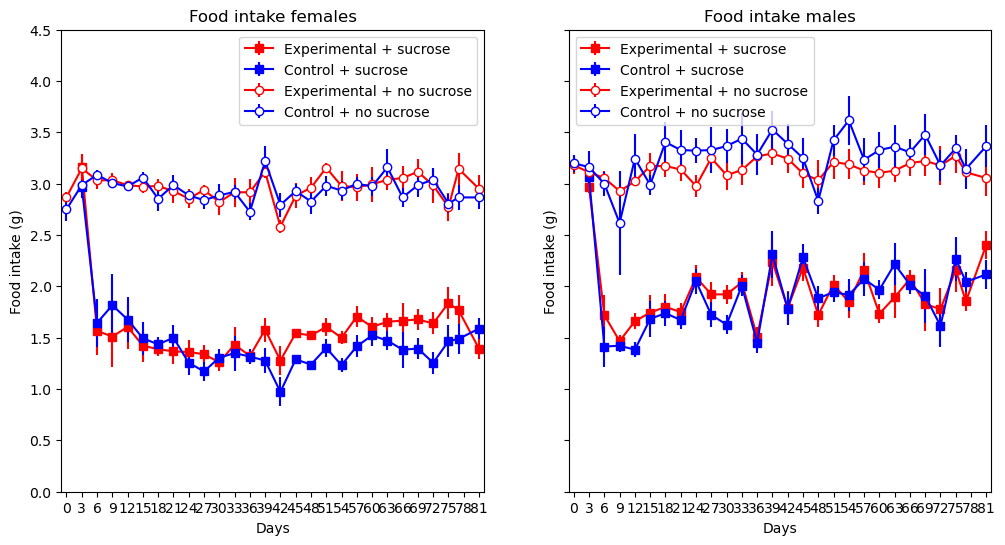

In [11]:
# Find mean and SEM of all data - food intake
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([0, 4.5])

# Add labels
ax[0].set_ylabel("Food intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Food intake females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([0, 4.5])

# Add labels
ax[1].set_ylabel("Food intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Food intake males")


f.savefig("..//results//foodintake.png")

In [12]:
## for when you kinda want the dots/datapoints of the graph not to overlap, add this to some of them
## use it instead of the x at the errorbar
[xval + 0.1 for xval in x]

[0.1,
 3.1,
 6.1,
 9.1,
 12.1,
 15.1,
 18.1,
 21.1,
 24.1,
 27.1,
 30.1,
 33.1,
 36.1,
 39.1,
 42.1,
 45.1,
 48.1,
 51.1,
 54.1,
 57.1,
 60.1,
 63.1,
 66.1,
 69.1,
 72.1,
 75.1,
 77.1,
 81.1]

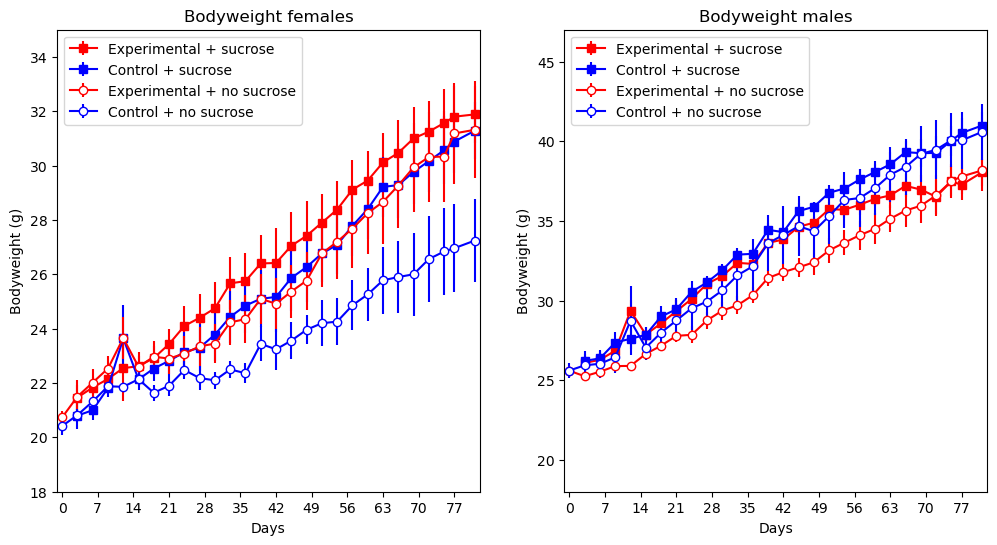

In [52]:
# Find mean and SEM of all data - body weight
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=False,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[0].set_ylim([18, 35])

# Add labels
ax[0].set_ylabel("Bodyweight (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Bodyweight females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[1].set_ylim([18, 47])

# Add labels
ax[1].set_ylabel("Bodyweight (g)")
ax[1].set_xlabel("Days")
ax[1].legend(loc="upper left")
ax[1].set_title("Bodyweight males")


f.savefig("..//results//bodyweight.png")

In [14]:
# sucrose has some outliers as well, that will be removed in this cell. The cleaned dataset will be stored in a 
# new dataset.

def replace_outliers(df_food_water, column):
    values = []
    for idx, row in df_food_water.iterrows():
        if row[column] in [-1, -2]:  # Checking for both -1 and -2
            values.append(np.nan)
        else:
            values.append(row[column])

    print("The number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df_food_water[column] = values
    mean_by_animal = df_food_water.groupby(["animal_id"]).mean(numeric_only=True).reset_index()

    values = []
    for idx, row in df_food_water.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])

    return values

def remove_and_clean(df_food_water):
    return (df_food_water
            .assign(food_intake=lambda df_food_water: replace_outliers(df_food_water, "sucrose_intake")))

df_sucrose = remove_and_clean(df_food_water)


The number of outliers being replaced for sucrose_intake is 695


In [15]:
import numpy as np
import pandas as pd

def replace_outliers(df_food_water, column):
    values = []
    for idx, row in df_food_water.iterrows():
        if row[column] in [-1, -2]:  # Checking for both -1 and -2
            values.append(np.nan)
        else:
            values.append(row[column])

    print("The number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df_food_water[column] = values
    mean_by_animal = df_food_water.groupby(["animal_id"]).mean(numeric_only=True).reset_index()

    values = []
    for idx, row in df_food_water.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])

    return values

def remove_and_clean(df_food_water):
    df_food_water['food_intake'] = replace_outliers(df_food_water, "food_intake")
    df_food_water['sucrose_intake'] = replace_outliers(df_food_water, "sucrose_intake")
    return df_food_water

df_sucrose = remove_and_clean(df_food_water)

The number of outliers being replaced for food_intake is 0
The number of outliers being replaced for sucrose_intake is 695


In [16]:
df_sucrose.tail(20)

,animal_id,sex,diet,date,sucrose,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,None,None,None,groupn
1372,B3229,male,control,2024-06-29 00:00:00,No,39.6,56.6,45.9,3.566667,-1,-1,NaN,None,None,None,5
1373,B3230,male,control,2024-06-29 00:00:00,No,32.6,40.5,32.4,2.700000,-1,-1,NaN,None,None,None,5
1374,B3231,male,experimental,2024-06-29 00:00:00,No,39.4,51.9,42.8,3.033333,-1,-1,NaN,None,None,None,7
1375,B3232,male,experimental,2024-06-29 00:00:00,No,34.1,47.2,40.1,2.366667,-1,-1,NaN,None,None,None,7
1376,B3233,male,experimental,2024-06-29 00:00:00,Yes,35.2,72.4,64.5,2.633333,55.1,45.1,3.333333,None,None,None,6
1377,B3234,male,experimental,2024-06-29 00:00:00,Yes,36.4,38.4,32.4,2.000000,54.5,44.5,3.333333,None,None,None,6
1378,B3235,male,control,2024-06-29 00:00:00,Yes,39.4,63.6,57.2,2.133333,55.5,39.6,5.300000,None,None,None,4
1379,B3236,male,control,2024-06-29 00:00:00,Yes,43.9,37.1,31.1,2.000000,54.3,43.3,3.666667,None,None,None,4
1380,B3237,male,experimental,2024-06-29 00:00:00,Yes,42.1,59.2,51.4,2.600000,55.2,47.3,2.633333,None,None,None,6
1381,B3238,male,experimental,2024-06-29 00:00:00,Yes,37.2,45.3,37.3,2.666667,54.4,42.2,4.066667,None,None,None,6


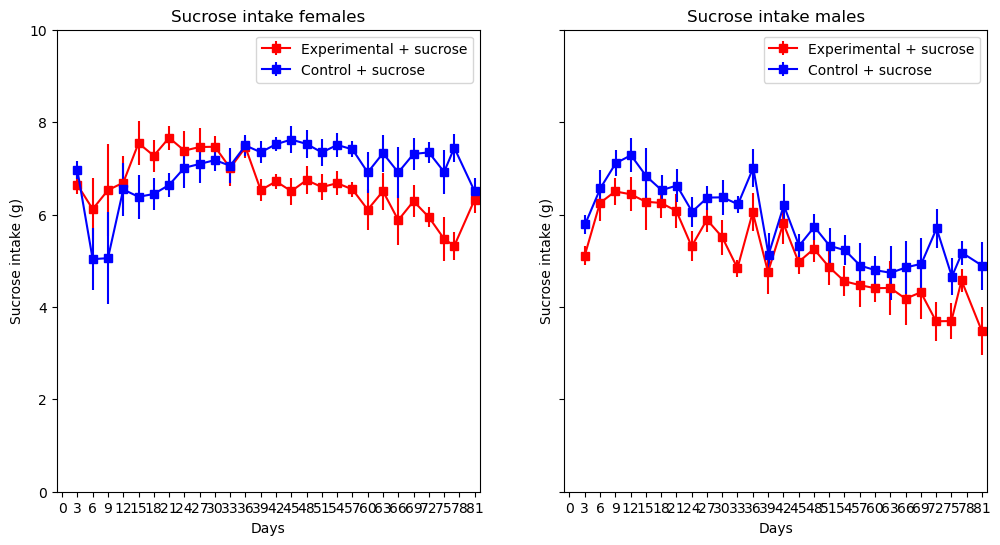

In [17]:
# Find mean and SEM of all data - sucrose intake
mean_fw = df_sucrose.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_sucrose.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([0, 10])

# Add labels
ax[0].set_ylabel("Sucrose intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Sucrose intake females")

# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([0, 10])

# Add labels
ax[1].set_ylabel("Sucrose intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Sucrose intake males")


f.savefig("..//results//sucroseintake.png")

In [18]:
#new factor: ratio of calories from sucrose:food
df_sucrose['calories_food'] = df_sucrose['food_intake'] * 4.081
df_sucrose['calories_sucrose'] = df_sucrose['sucrose_intake'] * 0.3 * 3.94
df_sucrose['ratio'] = df_sucrose['calories_sucrose'] / df_sucrose['calories_food']

In [19]:
df_sucrose.tail(50)

## it seems to be the case that in the dataframe, food intake is equal to sucrose intake

,animal_id,sex,diet,date,sucrose,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,None,None,None,groupn,calories_food,calories_sucrose,ratio
1341,B3246,male,experimental,2024-06-26 00:00:00,No,41.9,56.3,46.3,3.333333,-1,-1,NaN,None,None,None,7,13.603333,NaN,NaN
1342,B3247,male,experimental,2024-06-26 00:00:00,Yes,34.3,30.8,25.6,1.733333,54.9,37.1,5.933333,None,None,None,6,7.073733,7.013200,0.991443
1343,B3248,male,experimental,2024-06-26 00:00:00,Yes,42.6,42.3,36.1,2.066667,54.5,43.8,3.566667,None,None,None,6,8.434067,4.215800,0.499854
1345,B3202,female,control,2024-06-29 00:00:00,No,31.9,61.2,53.2,2.666667,-1,-1,NaN,None,None,None,1,10.882667,NaN,NaN
1346,B3203,female,experimental,2024-06-29 00:00:00,No,37.3,80.8,64.8,2.666667,-1,-1,NaN,None,None,None,3,10.882667,NaN,NaN
1347,B3204,female,experimental,2024-06-29 00:00:00,No,24.5,80.8,64.8,2.666667,-1,-1,NaN,None,None,None,3,10.882667,NaN,NaN
1348,B3205,female,control,2024-06-29 00:00:00,No,27.9,49.5,39.8,3.233333,-1,-1,NaN,None,None,None,1,13.195233,NaN,NaN
1349,B3206,female,control,2024-06-29 00:00:00,No,24.3,38.6,29.5,3.033333,-1,-1,NaN,None,None,None,1,12.379033,NaN,NaN
1350,B3207,female,experimental,2024-06-29 00:00:00,No,29.9,72.6,63,3.200000,-1,-1,NaN,None,None,None,3,13.059200,NaN,NaN
1351,B3208,female,experimental,2024-06-29 00:00:00,No,34.5,49.3,38.9,3.466667,-1,-1,NaN,None,None,None,3,14.147467,NaN,NaN


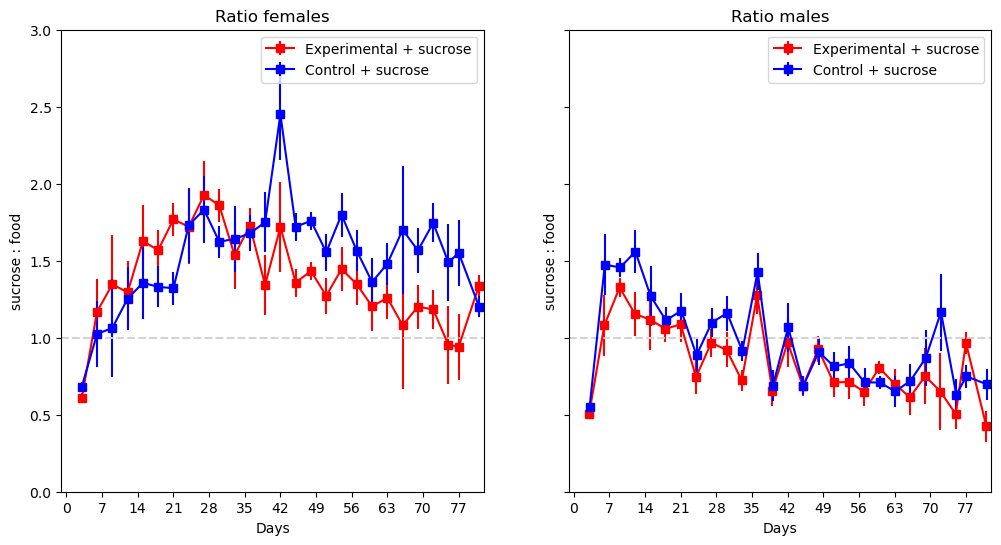

In [20]:
# Find mean and SEM of all data - ratio calories
mean_fw = df_sucrose.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_sucrose.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").ratio,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").ratio,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[0].set_ylim([0, 3])

# Add labels
ax[0].set_ylabel("sucrose : food")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Ratio females")

# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,77,81]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").ratio,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").ratio,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").ratio,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

#Lines at a ratio of 1
ax[0].axhline(y=1, linestyle='--', color='lightgray')
ax[1].axhline(y=1, linestyle='--', color='lightgray')

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 7)) 
ax[1].set_ylim([0, 3])

# Add labels
ax[1].set_ylabel("sucrose : food")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Ratio males")


f.savefig("..//results//calories.png")

Text(0.5, 1.0, 'Female control no sucrose data')

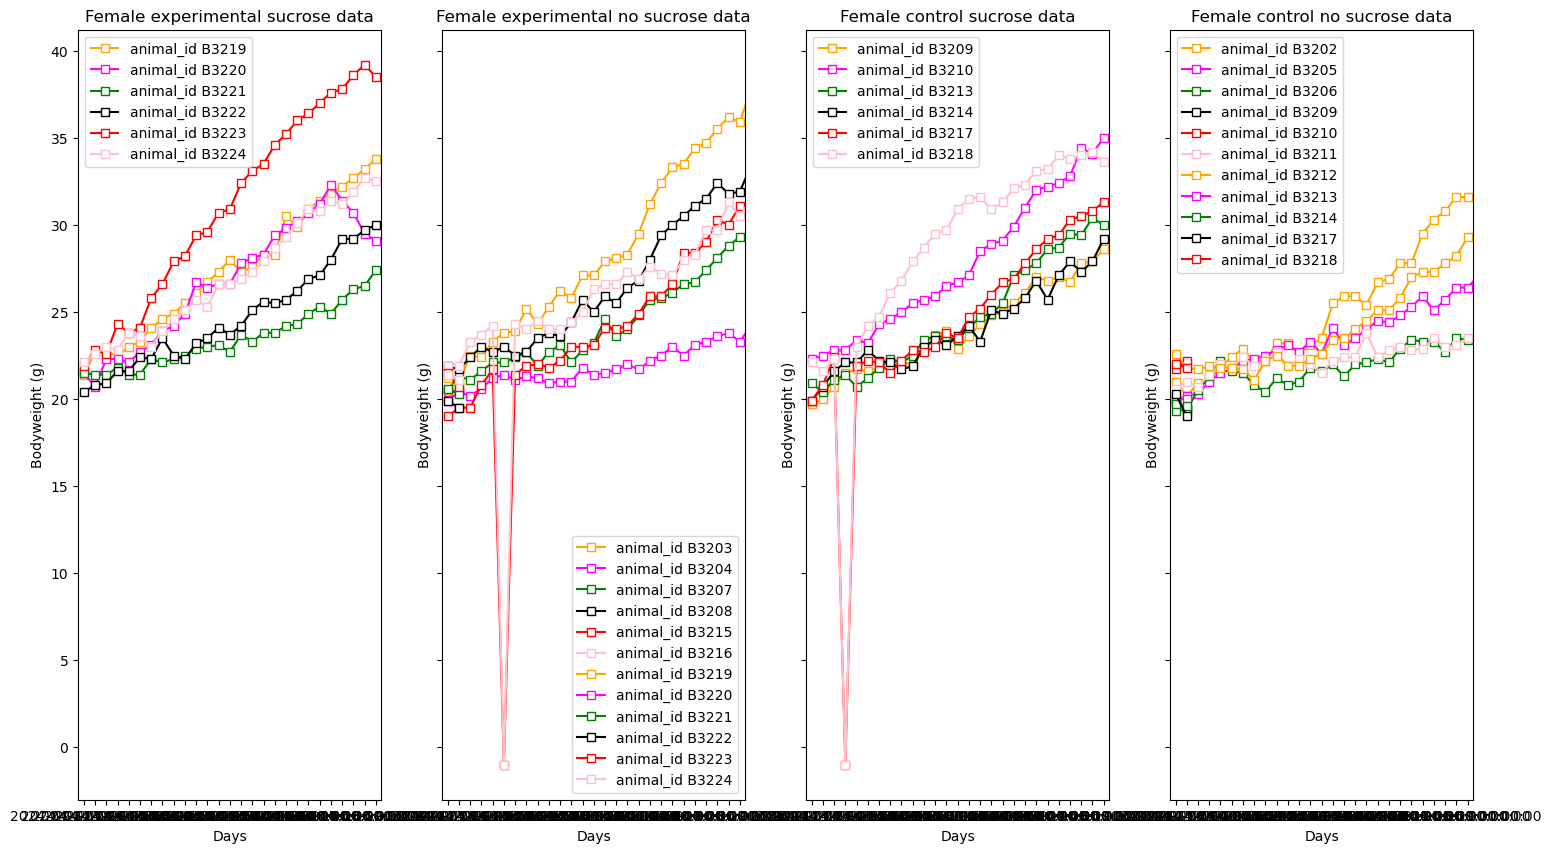

In [21]:
#Now look at the body weight for all individuals (in case some individuals respond weirdly / a lot whilst others don't at all)
#Females first

#Subset the DataFrames into four
female_experimental_sucrose_data = df[(df['sex'] == 'female') & (df['diet'] == 'experimental') & (df['sucrose'] == 'Yes')]
female_experimental_no_sucrose_data = df[(df['sex'] == 'female') & (df['diet'] == 'experimental') & (df['sucrose'] == 'No')]
female_control_sucrose_data = df[(df["sex"] == "female") & (df["diet"] == "control") & (df['sucrose'] == 'Yes')]
female_control_no_sucrose_data = df[(df["sex"] == "female") & (df["diet"] == "control") & (df['sucrose'] == 'No')]

# Set x values based on the number of days
x_values0 = np.arange(len(female_experimental_sucrose_data['date'].unique()))
x_values1 = np.arange(len(female_experimental_no_sucrose_data['date'].unique()))
x_values2 = np.arange(len(female_control_sucrose_data['date'].unique()))
x_values3 = np.arange(len(female_control_no_sucrose_data['date'].unique()))

# Create a subplot
fig, ax = plt.subplots(ncols=4, figsize=(18, 10), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1, 1, 1]})

# Get unique samples in the dataset
samples0 = female_experimental_sucrose_data['animal_id'].unique()
samples1 = female_experimental_no_sucrose_data['animal_id'].unique()
samples2 = female_control_sucrose_data["animal_id"].unique()
samples3 = female_control_no_sucrose_data["animal_id"].unique()

# Colour of lines
palette = ["orange", "magenta", "green", "black", "red", "pink"]

# Loop through each sample and plot the connected data points
for i, sample in enumerate(samples0):
    sample_data = female_experimental_sucrose_data[female_experimental_sucrose_data['animal_id'] == sample]
    ax[0].plot(x_values0[:len(sample_data)], 
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples1):
    sample_data = female_experimental_no_sucrose_data[female_experimental_no_sucrose_data['animal_id'] == sample]
    ax[1].plot(x_values1[:len(sample_data)],  
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples2):
    sample_data = female_control_sucrose_data[female_control_sucrose_data['animal_id'] == sample]
    ax[2].plot(x_values2[:len(sample_data)],  
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples3):
    sample_data = female_control_no_sucrose_data[female_control_no_sucrose_data['animal_id'] == sample]
    ax[3].plot(x_values3[:len(sample_data)], 
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

# Set x axis limits and ticks
for i in range(4):
    ax[i].set_xlim([-0.5, len(x_values0) - 0.5])
    ax[i].set_xticks(np.arange(len(x_values0)))
    ax[i].set_xticklabels(sorted(female_experimental_sucrose_data['date'].unique()))

    # Add labels
    ax[i].set_ylabel("Bodyweight (g)")
    ax[i].set_xlabel("Days")
    ax[i].legend()

# Set titles for each subplot
ax[0].set_title("Female experimental sucrose data")
ax[1].set_title("Female experimental no sucrose data")
ax[2].set_title("Female control sucrose data")
ax[3].set_title("Female control no sucrose data")

##FOR WHATEVER REASON THE GRAPHS ARE STILL WRONG


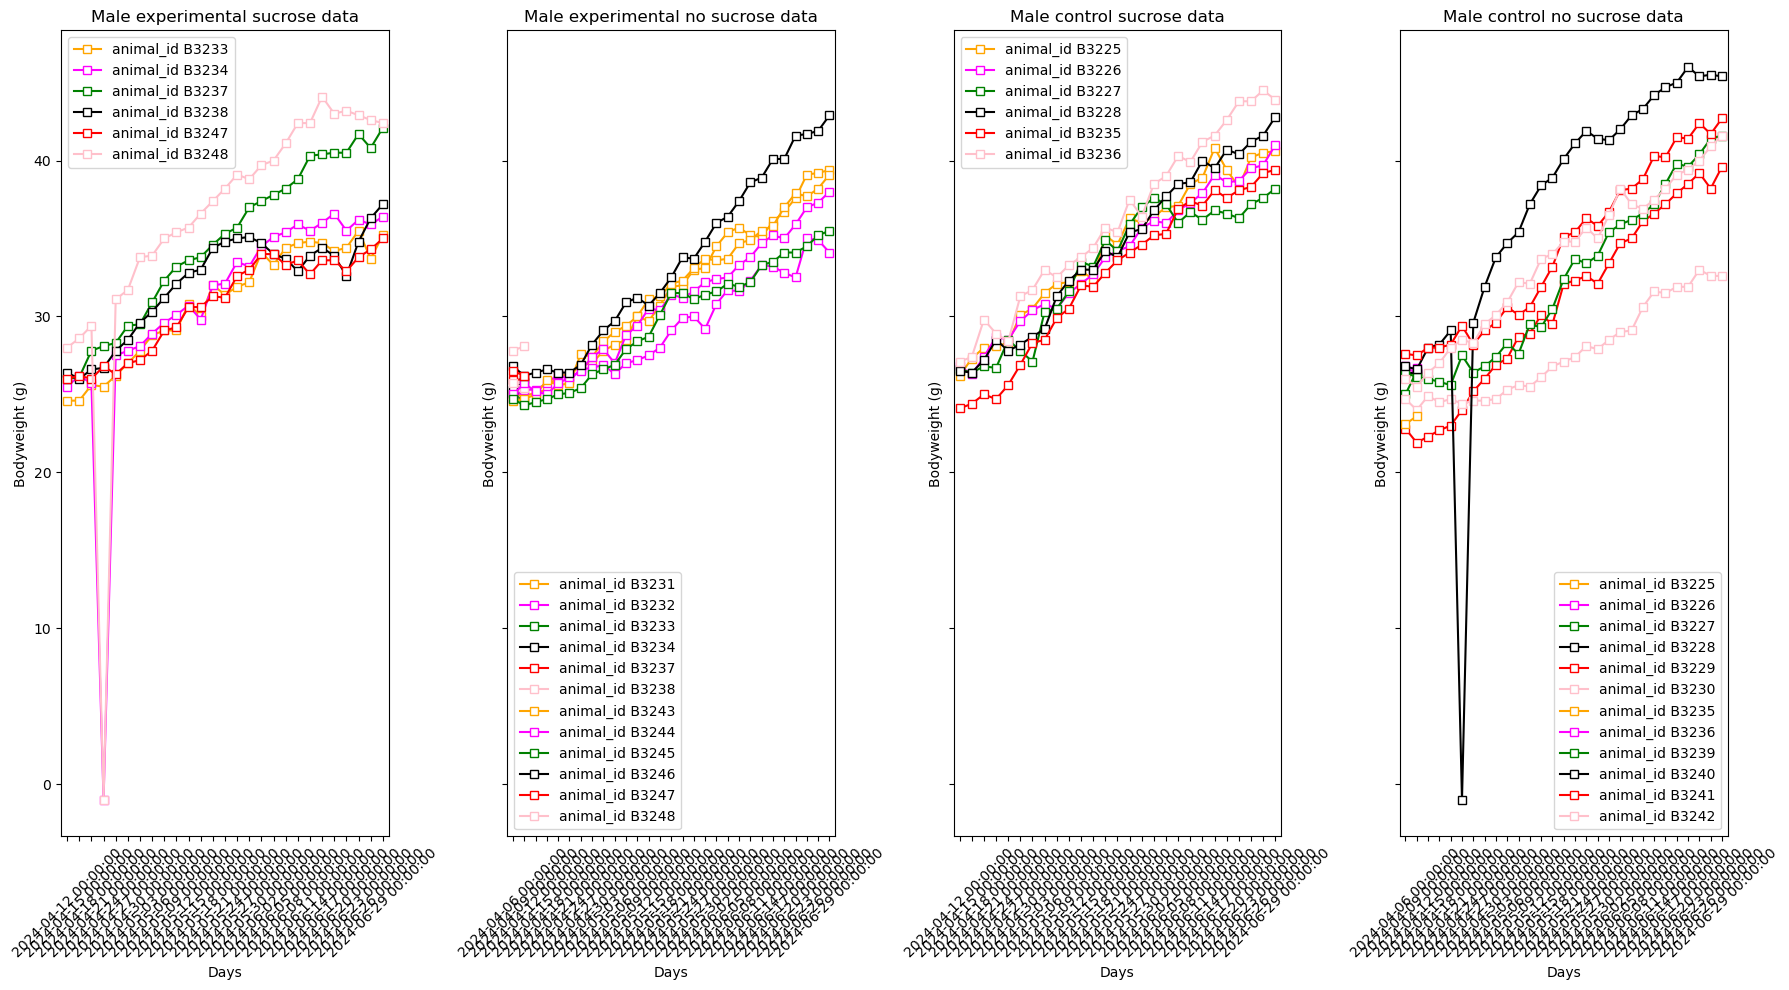

In [22]:
#Now the males

# Subset the DataFrames into four
male_experimental_sucrose_data = df[(df['sex'] == 'male') & (df['diet'] == 'experimental') & (df['sucrose'] == 'Yes')]
male_experimental_no_sucrose_data = df[(df['sex'] == 'male') & (df['diet'] == 'experimental') & (df['sucrose'] == 'No')]
male_control_sucrose_data = df[(df["sex"] == "male") & (df["diet"] == "control") & (df['sucrose'] == 'Yes')]
male_control_no_sucrose_data = df[(df["sex"] == "male") & (df["diet"] == "control") & (df['sucrose'] == 'No')]

# Set x values based on the number of days
x_values4 = np.arange(len(male_experimental_sucrose_data['date'].unique()))
x_values5 = np.arange(len(male_experimental_no_sucrose_data['date'].unique()))
x_values6 = np.arange(len(male_control_sucrose_data['date'].unique()))
x_values7 = np.arange(len(male_control_no_sucrose_data['date'].unique()))

# Create a subplot
fig, ax = plt.subplots(ncols=4, figsize=(18, 10), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1, 1, 1]})

# Get unique samples in the dataset
samples4 = male_experimental_sucrose_data["animal_id"].unique()
samples5 = male_experimental_no_sucrose_data["animal_id"].unique()
samples6 = male_control_sucrose_data["animal_id"].unique()
samples7 = male_control_no_sucrose_data["animal_id"].unique()

# Colour of lines
palette = ["orange", "magenta", "green", "black", "red", "pink"]

# Loop through each sample and plot the connected data points
for i, sample in enumerate(samples4):
    sample_data = male_experimental_sucrose_data[male_experimental_sucrose_data['animal_id'] == sample]
    ax[0].plot(x_values4[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")
    
for i, sample in enumerate(samples5):
    sample_data = male_experimental_no_sucrose_data[male_experimental_no_sucrose_data['animal_id'] == sample]
    ax[1].plot(x_values5[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples6):
    sample_data = male_control_sucrose_data[male_control_sucrose_data['animal_id'] == sample]
    ax[2].plot(x_values6[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples7):
    sample_data = male_control_no_sucrose_data[male_control_no_sucrose_data['animal_id'] == sample]
    ax[3].plot(x_values7[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

# Set x axis limits and ticks
for i, x_values in enumerate([x_values4, x_values5, x_values6, x_values7]):
    ax[i].set_xlim([-0.5, len(x_values) - 0.5])
    ax[i].set_xticks(np.arange(len(x_values)))
    unique_dates = sorted(eval(f'male_experimental_sucrose_data["date"].unique()')) if i == 0 else sorted(eval(f'male_experimental_no_sucrose_data["date"].unique()')) if i == 1 else sorted(eval(f'male_control_sucrose_data["date"].unique()')) if i == 2 else sorted(eval(f'male_control_no_sucrose_data["date"].unique()'))
    ax[i].set_xticklabels(unique_dates, rotation=45)

    # Add labels
    ax[i].set_ylabel("Bodyweight (g)")
    ax[i].set_xlabel("Days")
    ax[i].legend()

# Set titles for each subplot
ax[0].set_title("Male experimental sucrose data")
ax[1].set_title("Male experimental no sucrose data")
ax[2].set_title("Male control sucrose data")
ax[3].set_title("Male control no sucrose data")

plt.tight_layout()

##FOR WHATEVER REASON THE GRAPHS ARE STILL WRONG

# Data analysis

So first, want to make a factor for the difference in body weight at the beginning and the end of the experiment. 

In [23]:
# Pivot the DataFrame to get weights for specific dates in separate columns, store it in a new one from the previously cleaned up one
df_pivot = df_food_water.pivot(index='animal_id', columns='date', values='bodyweight').reset_index() 

# Calculate the average of the first two and last two dates
dates_first_two = [pd.Timestamp('2024-04-09 00:00:00'), pd.Timestamp('2024-04-12 00:00:00')]  #here data's from the beginning
dates_last_two = [pd.Timestamp('2024-06-29 00:00:00'), pd.Timestamp('2024-06-26 00:00:00')] #here data's from the end

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot['avg_first_two'] = df_pivot[dates_first_two].mean(axis=1)
df_pivot['avg_last_two'] = df_pivot[dates_last_two].mean(axis=1)

# Calculate the difference between these averages
df_pivot['delta_bw'] = df_pivot['avg_last_two'] - df_pivot['avg_first_two']  #now the new factor is made 

In [24]:
df_pivot = df_pivot.assign(groupn= [1,3,3,1,1,3,3,0,0,1,1,0,0,3,3,0,0,2,2,2,2,2,2,4,4,4,4,5,5,7,7,6,6,4,4,6,6,5,5,5,5,7,7,7,7,6,6]) # manually assign dan maar denk ik 

In [25]:
df_pivot.head() #to check if the data set looks like I want it to 

date,animal_id,2024-04-09 00:00:00,2024-04-12 00:00:00,2024-04-15 00:00:00,2024-04-18 00:00:00,2024-04-21 00:00:00,2024-04-24 00:00:00,2024-04-27 00:00:00,2024-04-30 00:00:00,2024-05-03 00:00:00,...,2024-06-14 00:00:00,2024-06-17 00:00:00,2024-06-20 00:00:00,2024-06-23 00:00:00,2024-06-26 00:00:00,2024-06-29 00:00:00,avg_first_two,avg_last_two,delta_bw,groupn
0,B3202,20.2,20.9,21.0,21.9,22.4,22.9,22.1,22.2,23.2,...,30.3,30.8,31.6,31.6,31.8,31.9,20.55,31.85,11.30,1
1,B3203,20.9,22.5,22.4,23.3,23.8,23.9,25.2,24.3,25.3,...,34.7,35.5,36.2,35.9,37.8,37.3,21.70,37.55,15.85,3
2,B3204,20.4,20.2,20.6,21.2,21.4,21.1,21.3,21.2,20.9,...,23.3,23.6,23.8,23.3,24.2,24.5,20.30,24.35,4.05,3
3,B3205,20.2,20.3,21.0,21.5,21.7,22.2,22.3,22.5,22.8,...,25.1,25.7,26.4,26.4,27.1,27.9,20.25,27.50,7.25,1
4,B3206,19.4,20.5,21.3,22.2,21.6,21.5,20.8,20.4,21.2,...,23.3,22.7,23.5,23.4,23.6,24.3,19.95,23.95,4.00,1


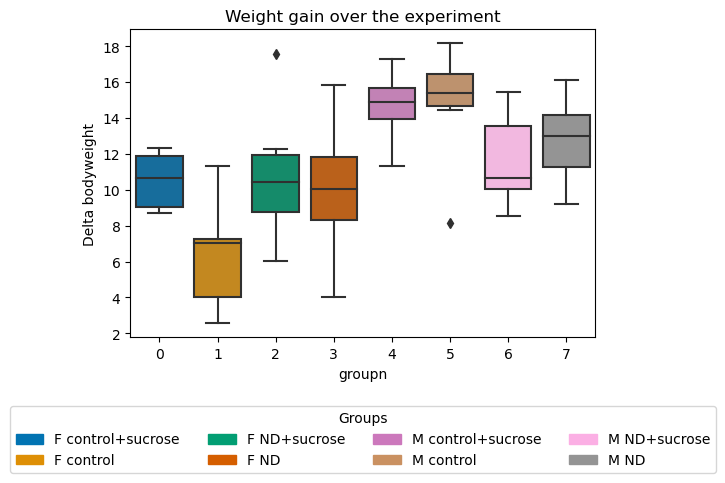

In [26]:
#visualise the new factor delta bodyweight in a boxplot
from matplotlib.patches import Patch

# Create a boxplot
plt.figure(figsize=(6, 4))
palette = sns.color_palette("colorblind",8)
sns.boxplot(x='groupn', y='delta_bw', palette = palette, data=df_pivot)

# Add title and labels
plt.title('Weight gain over the experiment')
plt.ylabel('Delta bodyweight')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)

f.savefig("..//results//bw_difference_new.png")

ANOVA

In [27]:
# Add to the dataframe information about sucrose access, sex and diet groups. 
df_pivot = df_pivot.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot = df_pivot.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot = df_pivot.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])
df_pivot.head()

date,animal_id,2024-04-09 00:00:00,2024-04-12 00:00:00,2024-04-15 00:00:00,2024-04-18 00:00:00,2024-04-21 00:00:00,2024-04-24 00:00:00,2024-04-27 00:00:00,2024-04-30 00:00:00,2024-05-03 00:00:00,...,2024-06-23 00:00:00,2024-06-26 00:00:00,2024-06-29 00:00:00,avg_first_two,avg_last_two,delta_bw,groupn,sex,sucrose,diet
0,B3202,20.2,20.9,21.0,21.9,22.4,22.9,22.1,22.2,23.2,...,31.6,31.8,31.9,20.55,31.85,11.30,1,female,No,control
1,B3203,20.9,22.5,22.4,23.3,23.8,23.9,25.2,24.3,25.3,...,35.9,37.8,37.3,21.70,37.55,15.85,3,female,No,experimental
2,B3204,20.4,20.2,20.6,21.2,21.4,21.1,21.3,21.2,20.9,...,23.3,24.2,24.5,20.30,24.35,4.05,3,female,No,experimental
3,B3205,20.2,20.3,21.0,21.5,21.7,22.2,22.3,22.5,22.8,...,26.4,27.1,27.9,20.25,27.50,7.25,1,female,No,control
4,B3206,19.4,20.5,21.3,22.2,21.6,21.5,20.8,20.4,21.2,...,23.4,23.6,24.3,19.95,23.95,4.00,1,female,No,control


In [28]:
df_pivot.to_csv("..//results//bodyweightchange.csv")

Shapiro-Wilk test p-value: 0.3922625780105591
A normal distribution of the data can be assumed.


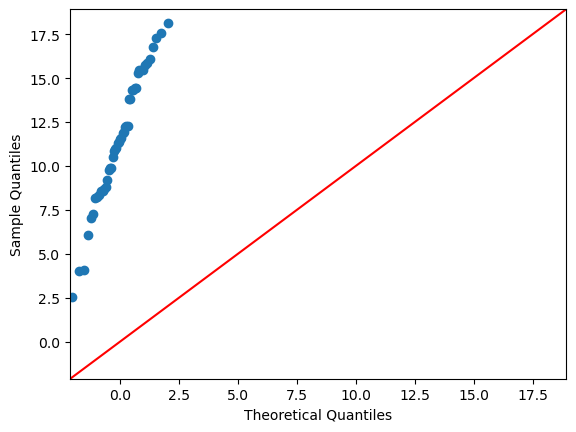

In [29]:
# perform tests on the data
# starting of by confirming the assumptions of an ANOVA

# normality
import statsmodels.api as sm
delta_bw = df_pivot['delta_bw']
fig = sm.qqplot(delta_bw, line='45') #sure it works but what does this say? 
# and am I even checking it correctly?

from scipy import stats
shapiro_test = stats.shapiro(delta_bw)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue) #okay the test says that it's normal

if shapiro_test.pvalue > 0.05:
    print("A normal distribution of the data can be assumed.")

In [30]:
#figuring out the equality of variances, using Levene's test
from statsmodels.formula.api import ols

# Fit the two-way ANOVA model
dependent_variable = 'delta_bw'
factor1 = 'diet'
factor2 = 'sucrose'
sex = 'sex'
formula = f'{dependent_variable} ~ C({factor1}) + C({factor2}) + C({sex}) + C({factor1}):C({factor2}) + C({factor1}):C({sex}) + C({factor2}):C({sex}) + C({factor1}):C({factor2}):C({sex})'
model = ols(formula, data=df_pivot).fit()

# Extract levels of each factor from the original DataFrame
factor1_levels = df_pivot[factor1].values
factor2_levels = df_pivot[factor2].values

# Calculate residuals from the fitted model
residuals = model.resid

# Calculate residuals for each combination of factor levels
grouped_residuals = []
for factor1_level in np.unique(factor1_levels):
    for factor2_level in np.unique(factor2_levels):
        mask = (factor1_levels == factor1_level) & (factor2_levels == factor2_level)
        grouped_residuals.append(residuals[mask])

# Perform Bartlett test for homogeneity of variances
bartlett_test = stats.bartlett(*grouped_residuals)
print("Bartlett test statistic:", bartlett_test.statistic)
print("Bartlett test p-value:", bartlett_test.pvalue)

if bartlett_test.statistic > 0.05:
    print("Equality of variances can be assumed.")

Bartlett test statistic: 4.6604622565400415
Bartlett test p-value: 0.19841627218571445
Equality of variances can be assumed.


In [31]:
#split the dataframe for sex
df_male = df_pivot[df_pivot['sex'] == 'male']
df_female = df_pivot[df_pivot['sex'] == 'female']


In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA for males
model = ols('delta_bw ~ C(sucrose) + C(diet) + C(sucrose):C(diet)', data=df_male).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(sucrose),2.130104,1.0,0.286782,0.598195
C(diet),37.625104,1.0,5.065577,0.035814
C(sucrose):C(diet),1.787604,1.0,0.240670,0.629062
Residual,148.552083,20.0,NaN,NaN


In [33]:
#perform two-way ANOVA for females
model = ols('delta_bw ~ C(sucrose) + C(diet) + C(sucrose):C(diet)', data=df_female).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(sucrose),32.391819,1.0,2.838242,0.108401
C(diet),20.382861,1.0,1.785991,0.197201
C(sucrose):C(diet),15.197813,1.0,1.331665,0.262819
Residual,216.840083,19.0,NaN,NaN


In [34]:
#3 way anova
model_full = ols('delta_bw ~ C(sucrose) + C(diet) + C(sex) + C(sucrose):C(diet) + C(sucrose):C(sex) + C(diet):C(sex) + C(sucrose):C(diet):C(sex)', data=df_pivot).fit()
print(sm.stats.anova_lm(model_full, typ=2))

                               sum_sq    df          F    PR(>F)
C(sucrose)                   8.604827   1.0   0.918433  0.343790
C(diet)                      1.518873   1.0   0.162116  0.689414
C(sex)                     176.921143   1.0  18.883614  0.000096
C(sucrose):C(diet)          13.539881   1.0   1.445174  0.236552
C(sucrose):C(sex)           26.801860   1.0   2.860687  0.098746
C(diet):C(sex)              57.781325   1.0   6.167269  0.017420
C(sucrose):C(diet):C(sex)    3.445537   1.0   0.367758  0.547743
Residual                   365.392167  39.0        NaN       NaN


can we do the same for calorie intake?

In [35]:
# Pivot the DataFrame to get weights for specific dates in separate columns, store it in a new one from the previously cleaned up one
df_pivot_calorie = df_food_water.pivot(index='animal_id', columns='date', values='ratio').reset_index() 
df_pivot_calorie = df_pivot_calorie.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_calorie = df_pivot_calorie.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_calorie = df_pivot_calorie.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [57]:
# get average of the values of ratio for every 3 weeks

##at the end, check the dates here!!!!!!
ratio_period1 = [pd.Timestamp('2024-04-09 00:00:00'),
       pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
ratio_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
ratio_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
ratio_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot_calorie['avg_period1'] = df_pivot_calorie[ratio_period1].mean(axis=1)
df_pivot_calorie['avg_period2'] = df_pivot_calorie[ratio_period2].mean(axis=1)
df_pivot_calorie['avg_period3'] = df_pivot_calorie[ratio_period3].mean(axis=1)
df_pivot_calorie['avg_period4'] = df_pivot_calorie[ratio_period4].mean(axis=1)

In [54]:
df_pivot_calorie.to_csv("..//results//calorie_intake.csv")

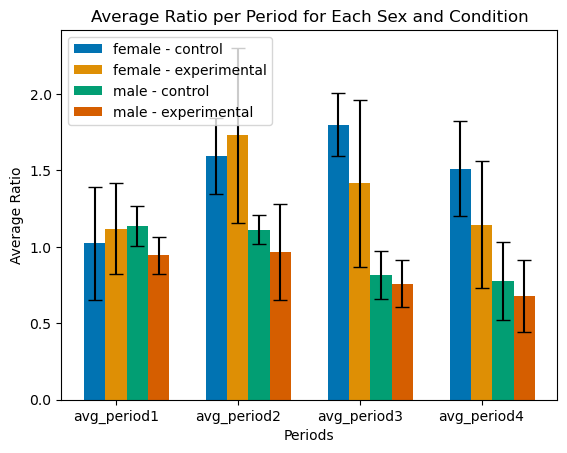

In [55]:
#Setting up the plot
periods = ['avg_period1', 'avg_period2', 'avg_period3', 'avg_period4']
sexes = df_pivot_calorie['sex'].unique()
conditions = ['control', 'experimental']
palette = sns.color_palette("colorblind", 4)

#Plotting
fig, ax = plt.subplots()

#Setting the bar width
bar_width = 0.35
num_conditions = len(conditions)

#Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

#indicate a colour map because otherwise later on I won't have 4 different colours
color_map = {
    ('female', 'control'): palette[0],
    ('female', 'experimental'): palette[1],
    ('male', 'control'): palette[2],
    ('male', 'experimental'): palette[3]
}

#Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].mean()
        errors = df_pivot_calorie[(df_pivot_calorie['sex'] == sex) & (df_pivot_calorie['diet'] == condition)][periods].std()
        bar_position = index + (i * num_conditions + j) * bar_width / num_conditions
        ax.bar(bar_position, values, bar_width / num_conditions, label=f'{sex} - {condition}', yerr=errors, capsize=5,color=color_map[sex,condition])

#Adding labels and title
ax.set_xlabel('Periods')
ax.set_ylabel('Average Ratio')
ax.set_title('Average Ratio per Period for Each Sex and Condition')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)
ax.legend()

Also make and store separate dataframes for food intake and sucrose intake separately

In [56]:
# food intake
df_pivot_food = df_food_water.pivot(index='animal_id', columns='date', values='food_intake').reset_index() 
df_pivot_food = df_pivot_food.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_food = df_pivot_food.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_food = df_pivot_food.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [58]:
# bin the food intake just as with calorie ratio
##at the end, check the dates here!!!!!!
food_period1 = [pd.Timestamp('2024-04-09 00:00:00'),
       pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
food_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
food_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
food_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot_food['avg_period1'] = df_pivot_food[food_period1].mean(axis=1)
df_pivot_food['avg_period2'] = df_pivot_food[food_period2].mean(axis=1)
df_pivot_food['avg_period3'] = df_pivot_food[food_period3].mean(axis=1)
df_pivot_food['avg_period4'] = df_pivot_food[food_period4].mean(axis=1)

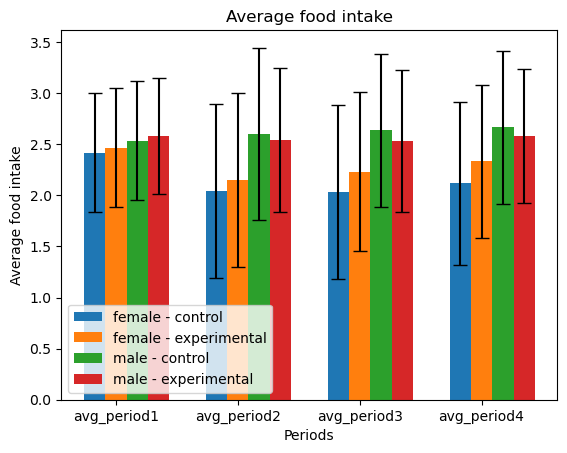

In [59]:
#Setting up the plot
periods = ['avg_period1', 'avg_period2', 'avg_period3', 'avg_period4']
sexes = df_pivot_food['sex'].unique()
conditions = ['control', 'experimental']

#Plotting
fig, ax = plt.subplots()

#Setting the bar width
bar_width = 0.35
num_conditions = len(conditions)

#Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

#Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_food[(df_pivot_food['sex'] == sex) & (df_pivot_food['diet'] == condition)][periods].mean()
        errors = df_pivot_food[(df_pivot_food['sex'] == sex) & (df_pivot_food['diet'] == condition)][periods].std()
        bar_position = index + (i * num_conditions + j) * bar_width / num_conditions
        ax.bar(bar_position, values, bar_width / num_conditions, label=f'{sex} - {condition}', yerr=errors, capsize=5)

#Adding labels and title
ax.set_xlabel('Periods')
ax.set_ylabel('Average food intake')
ax.set_title('Average food intake')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)
ax.legend()

In [60]:
df_pivot_food.to_csv("..//results//food_intake.csv")

In [61]:
# and now for sucrose intake
# food intake
df_pivot_sucrose = df_food_water.pivot(index='animal_id', columns='date', values='sucrose_intake').reset_index() 
df_pivot_sucrose = df_pivot_sucrose.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot_sucrose = df_pivot_sucrose.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot_sucrose = df_pivot_sucrose.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])

In [63]:
#bin it, again in 3 week blocks
# bin the food intake just as with calorie ratio
##at the end, check the dates here!!!!!!
sucrose_period1 = [pd.Timestamp('2024-04-09 00:00:00'),
       pd.Timestamp('2024-04-12 00:00:00'), pd.Timestamp('2024-04-15 00:00:00'),
       pd.Timestamp('2024-04-18 00:00:00'), pd.Timestamp('2024-04-21 00:00:00'),
       pd.Timestamp('2024-04-24 00:00:00'),pd.Timestamp('2024-04-27 00:00:00')]
sucrose_period2 = [pd.Timestamp('2024-05-18 00:00:00'), pd.Timestamp('2024-04-30 00:00:00'), pd.Timestamp('2024-05-03 00:00:00'),
       pd.Timestamp('2024-05-06 00:00:00'), pd.Timestamp('2024-05-09 00:00:00'),
       pd.Timestamp('2024-05-12 00:00:00'), pd.Timestamp('2024-05-15 00:00:00')]
sucrose_period3 = [pd.Timestamp('2024-06-08 00:00:00'), pd.Timestamp('2024-05-21 00:00:00'),
       pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00'),
       pd.Timestamp('2024-05-30 00:00:00'), pd.Timestamp('2024-06-02 00:00:00'),
       pd.Timestamp('2024-06-05 00:00:00')] 
sucrose_period4 = [pd.Timestamp('2024-06-11 00:00:00'),pd.Timestamp('2024-06-14 00:00:00')
                ,pd.Timestamp('2024-06-17 00:00:00'),pd.Timestamp('2024-06-20 00:00:00'),pd.Timestamp('2024-06-23 00:00:00')
                ,pd.Timestamp('2024-06-26 00:00:00'),pd.Timestamp('2024-06-29 00:00:00')]

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot_sucrose['avg_period1'] = df_pivot_sucrose[sucrose_period1].mean(axis=1)
df_pivot_sucrose['avg_period2'] = df_pivot_sucrose[sucrose_period2].mean(axis=1)
df_pivot_sucrose['avg_period3'] = df_pivot_sucrose[sucrose_period3].mean(axis=1)
df_pivot_sucrose['avg_period4'] = df_pivot_sucrose[sucrose_period4].mean(axis=1)

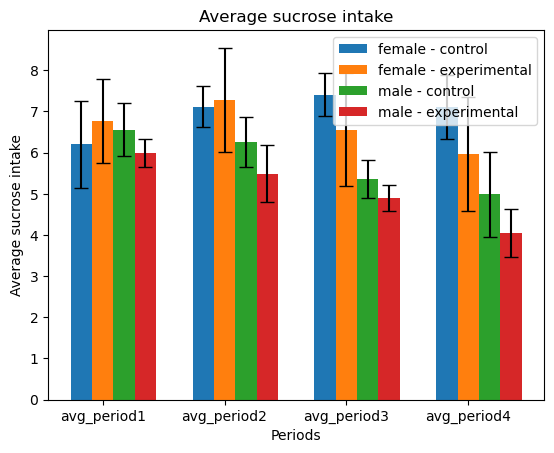

In [64]:
#Setting up the plot
periods = ['avg_period1', 'avg_period2', 'avg_period3', 'avg_period4']
sexes = df_pivot_sucrose['sex'].unique()
conditions = ['control', 'experimental']

#Plotting
fig, ax = plt.subplots()

#Setting the bar width
bar_width = 0.35
num_conditions = len(conditions)

#Setting the positions of the bars on the x-axis
index = np.arange(len(periods))

#Plotting for each sex and condition
for i, sex in enumerate(sexes):
    for j, condition in enumerate(conditions):
        values = df_pivot_sucrose[(df_pivot_sucrose['sex'] == sex) & (df_pivot_sucrose['diet'] == condition)][periods].mean()
        errors = df_pivot_sucrose[(df_pivot_sucrose['sex'] == sex) & (df_pivot_sucrose['diet'] == condition)][periods].std()
        bar_position = index + (i * num_conditions + j) * bar_width / num_conditions
        ax.bar(bar_position, values, bar_width / num_conditions, label=f'{sex} - {condition}', yerr=errors, capsize=5)

#Adding labels and title
ax.set_xlabel('Periods')
ax.set_ylabel('Average sucrose intake')
ax.set_title('Average sucrose intake')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(periods)
ax.legend()

In [46]:
df_pivot_sucrose.to_csv("..//results//sucrose_intake.csv")

# body composition

In [81]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "echoMRI_results.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="results")

In [82]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 1
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 2
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 3
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 4
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 5
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 6
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 7
    else:
        return -1

def tweak_df(df2):
    return (df2
            .astype({
                "sex": "category",
                "diet": "category", 
                "fat_old": float,
                "lean_old": float,
                "fat_new": float,
                "lean_new": float,
                "bodyweight_old": float,
                "bodyweight_new": float,
                "fat_change": float,
                "lean_change": float
            })
            .assign(groupn=lambda df2_: df2_.apply(get_value, axis=1))
    )

df2 = tweak_df(pd.DataFrame(rows, columns=header))


In [83]:
df2

,animal_id,sex,diet,sucrose,fat_old,lean_old,fat_new,lean_new,bodyweight_old,bodyweight_new,fat_change,lean_change,groupn
0,B3202,female,control,No,0.7475,17.8825,9.8525,20.8600,20.2,32.3,9.1050,2.9775,1
1,B3203,female,experimental,No,0.3575,18.4250,13.8700,22.8300,21.0,38.0,13.5125,4.4050,3
2,B3204,female,experimental,No,0.6300,17.2675,4.6450,18.9300,19.6,25.1,4.0150,1.6625,3
3,B3205,female,control,No,0.7350,17.4300,5.4350,21.6525,20.1,28.7,4.7000,4.2225,1
4,B3206,female,control,No,0.4575,16.8200,3.1125,19.9550,19.8,24.7,2.6550,3.1350,1
5,B3207,female,experimental,No,1.2375,17.0750,7.5850,19.9425,19.8,29.3,6.3475,2.8675,3
6,B3208,female,experimental,No,0.7175,18.5625,11.7750,21.4300,20.7,35.1,11.0575,2.8675,3
7,B3209,female,control,Yes,1.4725,16.4175,6.3025,21.1550,19.8,29.3,4.8300,4.7375,0
8,B3210,female,control,Yes,0.5175,18.2125,11.6550,22.0175,20.8,35.3,11.1375,3.8050,0
9,B3211,female,control,No,0.6450,17.4300,1.8625,20.7900,20.9,24.2,1.2175,3.3600,1


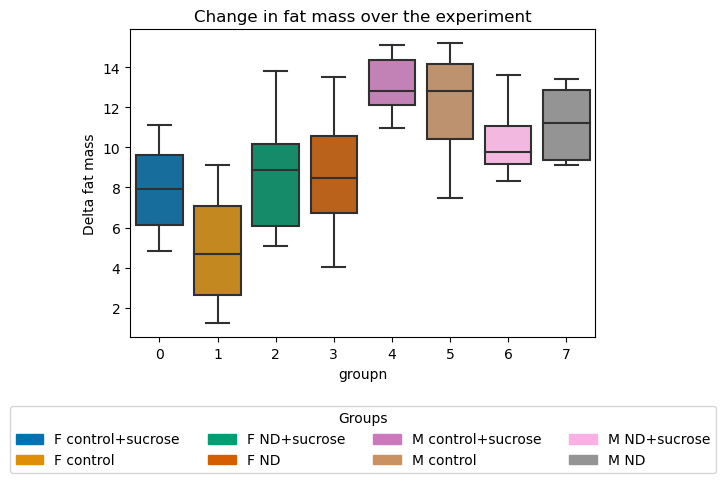

In [85]:
#visualise the new factor delta bodyweight in a boxplot
# Create a boxplot
plt.figure(figsize=(6, 4))
palette = sns.color_palette("colorblind",8)
sns.boxplot(x='groupn', y='fat_change', palette = palette, data=df2)

# Add title and labels
plt.title('Change in fat mass over the experiment')
plt.ylabel('Delta fat mass')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)


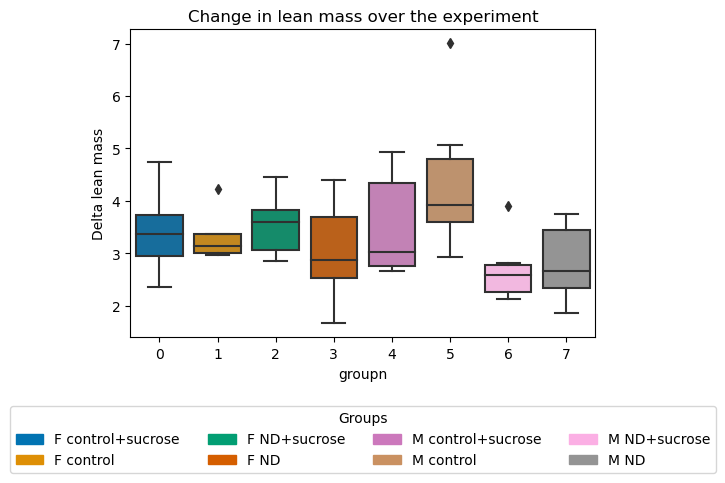

In [86]:
#visualise the new factor delta bodyweight in a boxplot
# Create a boxplot
plt.figure(figsize=(6, 4))
palette = sns.color_palette("colorblind",8)
sns.boxplot(x='groupn', y='lean_change', palette = palette, data=df2)

# Add title and labels
plt.title('Change in lean mass over the experiment')
plt.ylabel('Delta lean mass')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4)


In [ ]:
#ook maar even een ratiootje ofzo doen, of iig % van gewicht is vet en dan t verschil van % berekenen